In [42]:
import os
%matplotlib inline
import random
#import cPickle as pickle
import numpy as np
#from ggplot import *
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import matplotlib.pyplot 
from matplotlib.pyplot import imshow
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras import applications
from skimage.util.shape import view_as_windows
from skimage.transform import resize
from scipy.spatial import distance
from tqdm import tqdm
import pandas as pd

In [43]:
model = keras.applications.Xception(weights='imagenet', include_top=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [44]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
feat_extractor.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [63]:
images_path = '/hdd/vova/EMOJI/female/'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 120 images to analyze


In [64]:
features = []
thumbs = []
for i, image_path in tqdm(enumerate(images)):
    if i % 1000 == 0:
        print("analyzing image %d / %d" % (i, len(images)))
    img, x = load_image(image_path);
    
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
    thumbs.append(img)

print('finished extracting features for %d images' % len(images))

0it [00:00, ?it/s]

analyzing image 0 / 120


120it [00:19,  6.19it/s]

finished extracting features for 120 images


In [65]:
features = pd.DataFrame(features)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

120it [00:00, 316.73it/s]


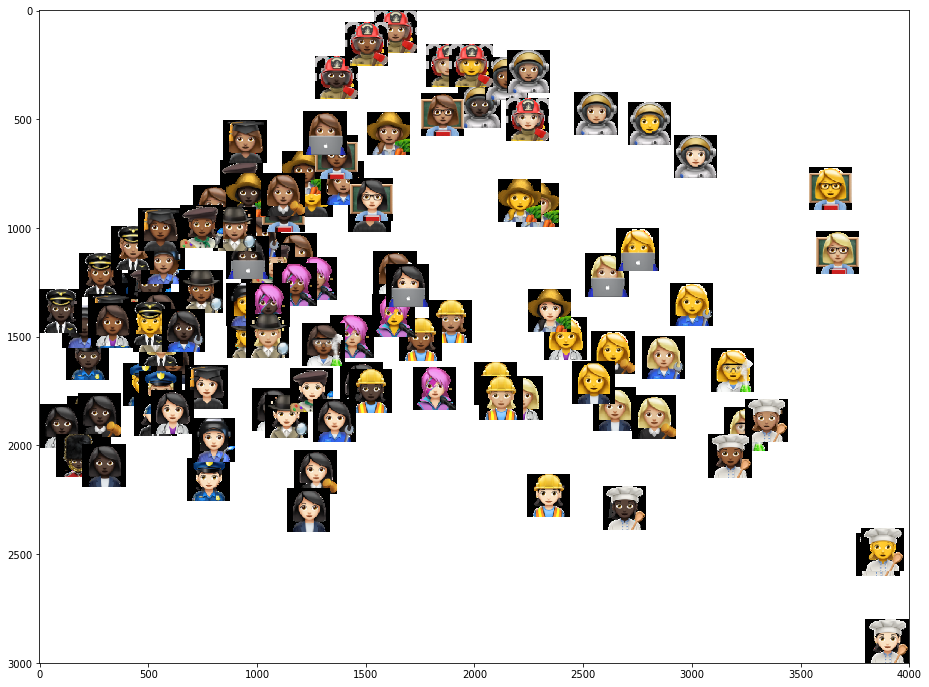

In [66]:
from PIL import Image
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

_pca = pca.fit(features).transform(features) 
#_pca = pca.fit(features_scaled).transform(features_scaled)  #scaled version

pca_df=pd.DataFrame(_pca,columns=['pc1','pc2'])

tx, ty = pca_df.pc1, pca_df.pc2
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

width = 4000
height = 3000
max_dim = 200

full_image = Image.new('RGBA', (width, height))
for img, x, y ,thumb in tqdm(zip(images, tx, ty, thumbs)):
    tile = thumb
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

[t-SNE] Computing 119 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 25.209997
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 50.5047226, gradient norm = 0.6351271 (50 iterations in 0.225s)
[t-SNE] Iteration 100: error = 52.2956161, gradient norm = 0.6253439 (50 iterations in 0.179s)
[t-SNE] Iteration 150: error = 50.7394409, gradient norm = 0.5593972 (50 iterations in 0.167s)
[t-SNE] Iteration 200: error = 51.1333313, gradient norm = 0.6295701 (50 iterations in 0.171s)
[t-SNE] Iteration 250: error = 51.1024704, gradient norm = 0.5441393 (50 iterations in 0.174s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.102470
[t-SNE] Iteration 300: error = 0.4089695, gradient norm = 0.0076015 (50 iterations in 0.173s)
[t-SNE] Iteration 350: error = 0.2997205, gradient norm = 0.0024810

0it [00:00, ?it/s]

[t-SNE] Iteration 850: error = 0.2193746, gradient norm = 0.0088587 (50 iterations in 0.172s)
[t-SNE] Iteration 900: error = 0.2695892, gradient norm = 0.0035399 (50 iterations in 0.171s)
[t-SNE] Iteration 900: did not make any progress during the last 300 episodes. Finished.
[t-SNE] Error after 900 iterations: 0.269589


120it [00:00, 311.12it/s]


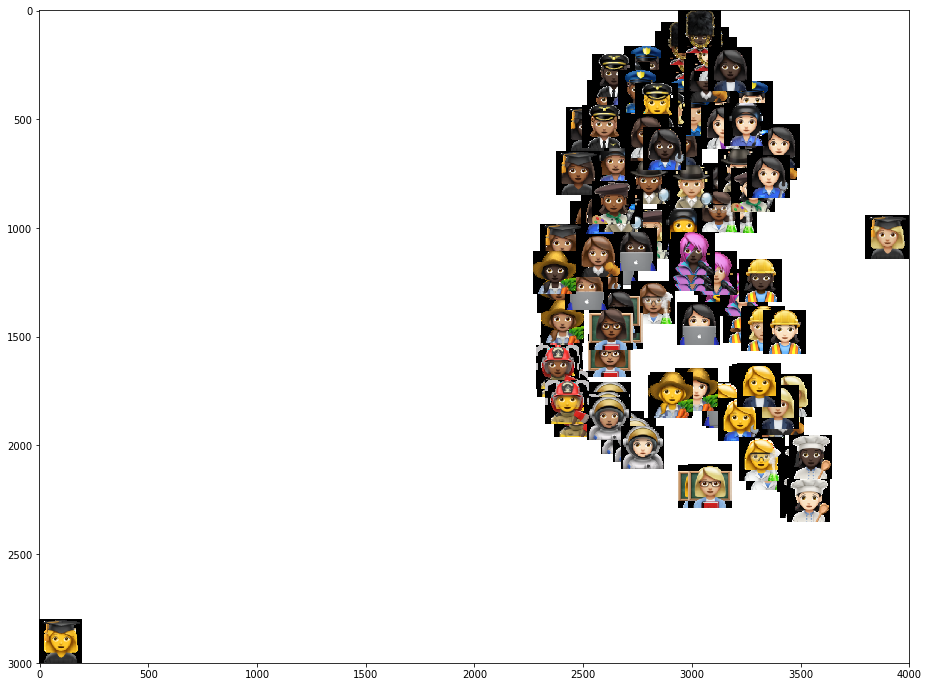

In [67]:
from sklearn.manifold import TSNE
pca = PCA(n_components=200)
_pca = pca.fit(features).transform(features)

X = np.array(_pca)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=55, angle=0.2, verbose=2).fit_transform(X)

tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

width = 4000
height = 3000
max_dim = 200

full_image = Image.new('RGBA', (width, height))
for img, x, y ,thumb in tqdm(zip(images, tx, ty, thumbs)):
    tile = thumb
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

120it [00:00, 369.56it/s]


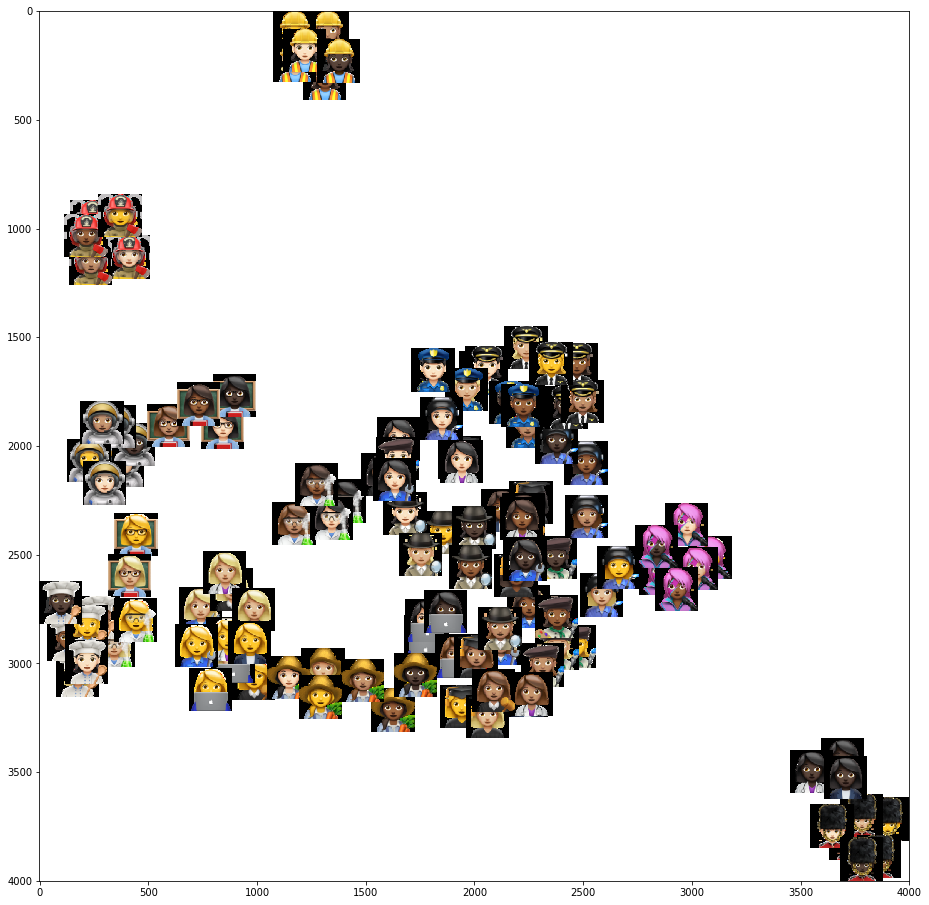

In [68]:
import umap
embedding = umap.UMAP(n_neighbors=7,
                      min_dist=0.9,
                      metric='correlation').fit_transform(features)
df = pd.DataFrame(embedding, columns=('x', 'y'))

tx, ty = df.x, df.y
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

width = 4000
height = 4000
max_dim = 200

full_image = Image.new('RGBA', (width, height))
for img, x, y ,thumb in tqdm(zip(images, tx, ty, thumbs)):
    tile = thumb
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,16))
imshow(full_image)